### 1. Install R packages

Uncomment section below if running for the first time

In [1]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("dada2")
# install.packages("magrittr")
# install.packages("stringr")
# install.packages("data.table")
# install.packages("broom")
# install.packages("qualpalr")
# install.packages("seqinr")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.0 (2021-05-18)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'dada2'”
Old packages: 'ape', 'clipr', 'commonmark', 'desc', 'DT', 'glue', 'linprog',
  'locfit', 'mgcv', 'openssl', 'psych', 'qgraph', 'Rcpp', 'RcppGSL', 'Rdpack',
  'rhdf5', 'rlang', 'rmarkdown', 'seriation', 'sn', 'survival', 'tidyselect',
  'tidytree', 'TSP', 'uuid', 'waldo', 'withr', 'xfun'

Warning message in install.packages("magrittr"):
“installation of package ‘magrittr’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Warning message in install.packages("data.table"):
“installation of package ‘data.

### 2. Load required libraries

In [2]:
library(dada2)
library(stringr)
library(data.table)
library(qualpalr)
library(ShortRead)
library(Biostrings)
library(seqinr)

Loading required package: Rcpp

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: BiocParallel

Loading required package: Biostrings

Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading

### 3. File path setup

In [3]:
rawpath <- "raw"
wdpath <- "/Users/mann/github/ads_plaque/05-rpoC_processing/" # change to where git repository was cloned
fnFs <- sort(list.files(rawpath, pattern="_R1_001.fastq.gz", full.names=T))
fnRs <- sort(list.files(rawpath, pattern="_R2_001.fastq.gz", full.names=T))
sample.names <- sapply(strsplit(basename(fnFs), "_"), `[`, 1)
head(sample.names, 50)
paste("Number of input samples: ", length(sample.names))

[1] "PCRBlank45" "PCRBlank46" "PCRBlank47" "UF102PFR"   "UF106PFR"  
 [6] "UF10PD"     "UF115PD"    "UF12PD"     "UF13PF"     "UF14PF"    
[11] "UF15PD"     "UF17PF"     "UF20PD"     "UF21PD"     "UF22PF"    
[16] "UF23PF"     "UF24PF"     "UF25PD"     "UF25PER"    "UF26PD"    
[21] "UF26PF"     "UF27PF"     "UF30PF"     "UF31PFR"    "UF32PF"    
[26] "UF33PF"     "UF35PFR"    "UF36PER"    "UF36PF"     "UF39PD"    
[31] "UF40PFR"    "UF42PD"     "UF42PER"    "UF43PD"     "UF44PD"    
[36] "UF46PD"     "UF47PD"     "UF47PER"    "UF48PF"     "UF49PD"    
[41] "UF49PDR"    "UF49PER"    "UF49PFR"    "UF50PER"    "UF51PD"    
[46] "UF52PD"     "UF52PDR"    "UF52PER"    "UF53PD"     "UF53PDR"

[1] "Number of input samples:  74"

### 4. Plot quality scores

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


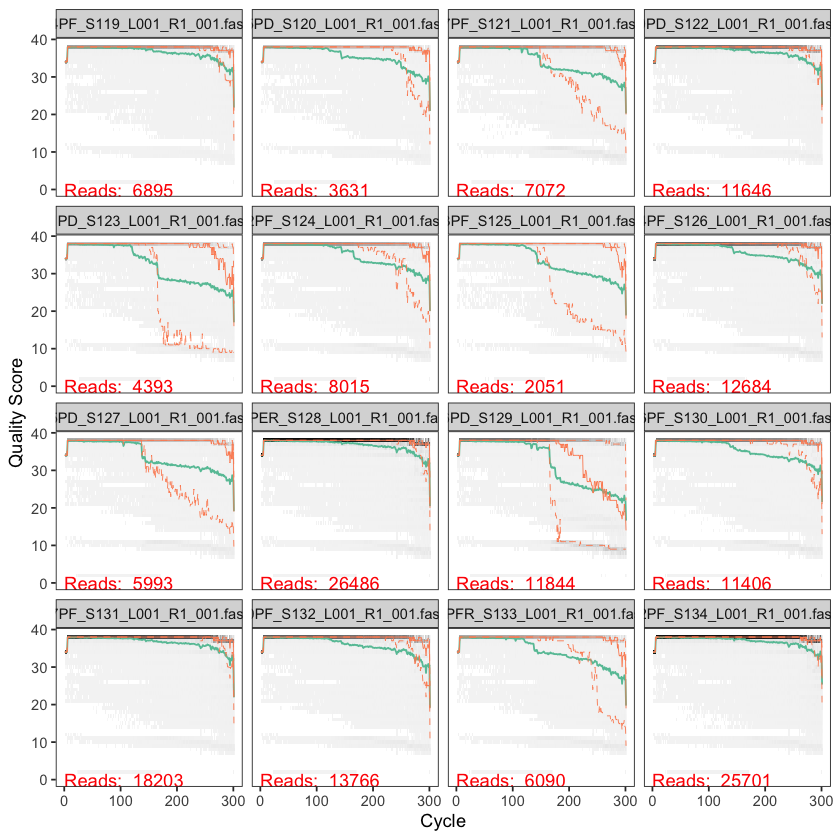

pdf 
  2

pdf 
  2

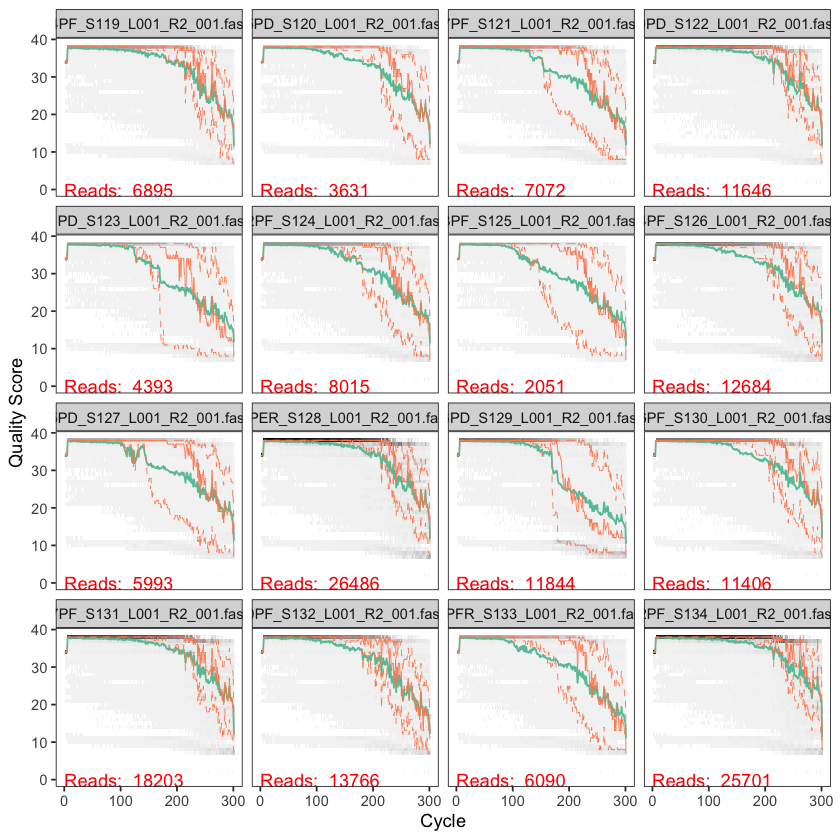

In [4]:
system("mkdir img") # ignore warning
fwdqual <- plotQualityProfile(fnFs[10:25])
revqual <- plotQualityProfile(fnRs[10:25])
fwdqual
revqual

pdf(paste(wdpath, "img/", "forward_quality_plot.pdf", sep=""))
fwdqual
dev.off()
pdf(paste(wdpath, "img/", "reverse_quality_plot.pdf", sep=""))
revqual
dev.off()


### 5. Preliminary filter (removes sequences with uncalled bases)

In [5]:
fnFs.filtN <- file.path(rawpath, "filtN", basename(fnFs)) # Put N-filtered files in filtN/ subdirectory
fnRs.filtN <- file.path(rawpath, "filtN", basename(fnRs))
filterAndTrim(fnFs, fnFs.filtN, fnRs, fnRs.filtN, maxN = 0, multithread = TRUE, compress = TRUE)

Creating output directory: raw/filtN



### 6. Primer removal 

In [6]:
cutadapt <- as.character(system("which cutadapt", intern=T))
system("cutadapt --version")
path.cut <- file.path(rawpath, "cutadapt")
if(!dir.exists(path.cut)) dir.create(path.cut)
fnFs.cut <- file.path(path.cut, basename(fnFs))
fnRs.cut <- file.path(path.cut, basename(fnRs))
FWD.RC <- dada2:::rc("MAYGARAARMGNATGYTNCARGA")
REV.RC <- dada2:::rc("GMCATYTGRTCNCCRTCRAA")
# Trim FWD and the reverse-complement of REV off of R1 (forward reads)
R1.flags <- paste("-g", "MAYGARAARMGNATGYTNCARGA", "-a", REV.RC) 
# Trim REV and the reverse-complement of FWD off of R2 (reverse reads)
R2.flags <- paste("-G", "GMCATYTGRTCNCCRTCRAA", "-A", FWD.RC) 
for(i in seq_along(fnFs)) {
  system2(cutadapt, args = c("--cores=0", R1.flags, R2.flags, "-n", 2,"-o", fnFs.cut[i], "-p", fnRs.cut[i], fnFs.filtN[i], fnRs.filtN[i]))
}
cutFs <- sort(list.files(path.cut, pattern = "R1", full.names = TRUE))
cutRs <- sort(list.files(path.cut, pattern = "R2", full.names = TRUE))

### 7. Filter and trim reads

In [7]:
filtFs <- file.path(path.cut, "filtered", basename(cutFs))
filtRs <- file.path(path.cut, "filtered", basename(cutRs))
out <- filterAndTrim(cutFs, filtFs, cutRs, filtRs, trimRight=25, maxN=c(0,0), maxEE=c(4,6), rm.phix=TRUE, matchIDs=TRUE, compress=TRUE, multithread=TRUE)
retained <- as.data.frame(out)
retained$percentage_retained <- retained$reads.out/retained$reads.in*100
retained

Creating output directory: raw/cutadapt/filtered



,reads.in,reads.out,percentage_retained
,<dbl>,<dbl>,<dbl>
PCRBlank45_S144_L001_R1_001.fastq.gz,1813,833,45.94595
PCRBlank46_S176_L001_R1_001.fastq.gz,8,8,100.00000
PCRBlank47_S192_L001_R1_001.fastq.gz,6254,5112,81.73969
UF102PFR_S113_L001_R1_001.fastq.gz,3384,2900,85.69740
UF106PFR_S114_L001_R1_001.fastq.gz,11281,9623,85.30272
UF10PD_S115_L001_R1_001.fastq.gz,5839,5510,94.36547
UF115PD_S116_L001_R1_001.fastq.gz,24981,23984,96.00897
UF12PD_S117_L001_R1_001.fastq.gz,3843,3355,87.30159
UF13PF_S118_L001_R1_001.fastq.gz,5618,5339,95.03382


### 8. Learn and plot error rates

104123973 total bases in 444189 reads from 49 samples will be used for learning the error rates.
105490137 total bases in 441190 reads from 41 samples will be used for learning the error rates.


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


pdf 
  2

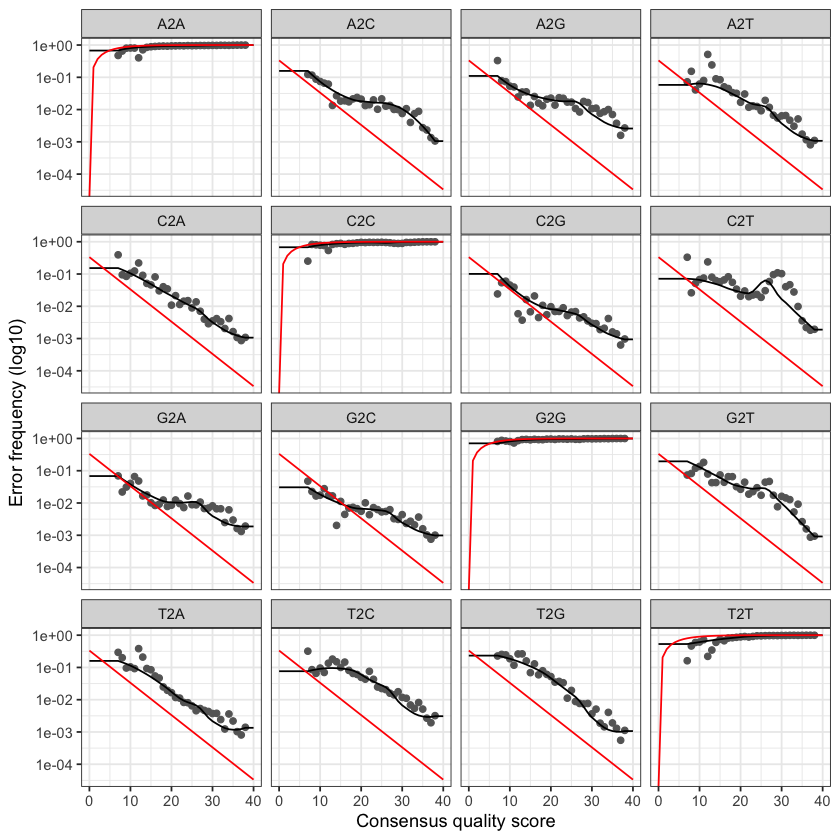

In [8]:
set.seed(12349)
errF <- learnErrors(filtFs, multithread=T, random=T)
errR <- learnErrors(filtRs, multithread=T, random=T)
err.f.plt <- plotErrors(errF, nominalQ=TRUE) 
err.f.plt
pdf(paste(wdpath, "img/", "error_plot.pdf", sep=""))
err.f.plt
dev.off()

### 9. Dereplication

In [10]:
derepFs <- derepFastq(filtFs, verbose=TRUE)
derepRs <- derepFastq(filtRs, verbose=TRUE)
# reassign sample names
sample.names <- sapply(strsplit(basename(filtFs), "_"), `[`, 1)
names(derepFs) <- sample.names
names(derepRs) <- sample.names

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank45_S144_L001_R1_001.fastq.gz

Encountered 147 unique sequences from 833 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank46_S176_L001_R1_001.fastq.gz

Encountered 8 unique sequences from 8 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank47_S192_L001_R1_001.fastq.gz

Encountered 1526 unique sequences from 5112 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF102PFR_S113_L001_R1_001.fastq.gz

Encountered 809 unique sequences from 2900 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF106PFR_S114_L001_R1_001.fastq.gz

Encountered 3058 unique sequences from 9623 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF10PD_S115_L001_R1_001.fastq.gz

Encountered 1819 unique sequences from 5510 to

Encountered 20 unique sequences from 40 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF53PDR_S159_L001_R1_001.fastq.gz

Encountered 1124 unique sequences from 3507 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF53PER_S161_L001_R1_001.fastq.gz

Encountered 1679 unique sequences from 4687 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF53PFR_S162_L001_R1_001.fastq.gz

Encountered 1147 unique sequences from 3309 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF54PD_S163_L001_R1_001.fastq.gz

Encountered 25 unique sequences from 41 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF54PER_S164_L001_R1_001.fastq.gz

Encountered 14683 unique sequences from 67125 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF55PF_S165_L001_R1_00

Encountered 2430 unique sequences from 4862 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF32PF_S134_L001_R2_001.fastq.gz

Encountered 10675 unique sequences from 24960 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF33PF_S135_L001_R2_001.fastq.gz

Encountered 6819 unique sequences from 14955 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF35PFR_S136_L001_R2_001.fastq.gz

Encountered 5035 unique sequences from 10643 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF36PER_S137_L001_R2_001.fastq.gz

Encountered 8171 unique sequences from 17871 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF36PF_S138_L001_R2_001.fastq.gz

Encountered 7497 unique sequences from 16838 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF39PD_S139_

Encountered 4252 unique sequences from 11409 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/UF8PF_S185_L001_R2_001.fastq.gz

Encountered 5359 unique sequences from 11060 total sequences read.



### 10. Sample inference

In [11]:
dadaFs <- dada(derepFs, err=errF, multithread=TRUE)
dadaRs <- dada(derepRs, err=errR, multithread=TRUE)

Sample 1 - 833 reads in 147 unique sequences.
Sample 2 - 8 reads in 8 unique sequences.
Sample 3 - 5112 reads in 1526 unique sequences.
Sample 4 - 2900 reads in 809 unique sequences.
Sample 5 - 9623 reads in 3058 unique sequences.
Sample 6 - 5510 reads in 1819 unique sequences.
Sample 7 - 23984 reads in 6746 unique sequences.
Sample 8 - 3355 reads in 1103 unique sequences.
Sample 9 - 5339 reads in 1681 unique sequences.
Sample 10 - 6404 reads in 2164 unique sequences.
Sample 11 - 3158 reads in 1015 unique sequences.
Sample 12 - 5278 reads in 1663 unique sequences.
Sample 13 - 11194 reads in 3199 unique sequences.
Sample 14 - 3319 reads in 804 unique sequences.
Sample 15 - 7222 reads in 2030 unique sequences.
Sample 16 - 1504 reads in 541 unique sequences.
Sample 17 - 11215 reads in 3652 unique sequences.
Sample 18 - 4286 reads in 1575 unique sequences.
Sample 19 - 25306 reads in 7289 unique sequences.
Sample 20 - 10868 reads in 1984 unique sequences.
Sample 21 - 9930 reads in 3063 uniq

### 11. Merge paired-end reads

In [12]:
mergers <- mergePairs(dadaFs, derepFs, dadaRs, derepRs, verbose=T)

289 paired-reads (in 4 unique pairings) successfully merged out of 830 (in 16 pairings) input.

1 paired-reads (in 1 unique pairings) successfully merged out of 1 (in 1 pairings) input.

4927 paired-reads (in 29 unique pairings) successfully merged out of 5093 (in 31 pairings) input.

2607 paired-reads (in 50 unique pairings) successfully merged out of 2805 (in 56 pairings) input.

9239 paired-reads (in 160 unique pairings) successfully merged out of 9341 (in 183 pairings) input.

5185 paired-reads (in 83 unique pairings) successfully merged out of 5342 (in 97 pairings) input.

23138 paired-reads (in 250 unique pairings) successfully merged out of 23334 (in 300 pairings) input.

3111 paired-reads (in 57 unique pairings) successfully merged out of 3272 (in 62 pairings) input.

5099 paired-reads (in 86 unique pairings) successfully merged out of 5149 (in 96 pairings) input.

6067 paired-reads (in 92 unique pairings) successfully merged out of 6211 (in 105 pairings) input.

3045 paired-re

### 12. Construct sequence table

In [13]:
seqtab <- makeSequenceTable(mergers)
dim(seqtab)

[1]   74 5312

### 13. Length filter

In [14]:
table(nchar(colnames(seqtab)))


  62   63   64   66   67   68   69   70   71   72   73   74   75   76   77   78 
   3   10    5    5   10    6    1    8    2   12    6    7    5   10    7    7 
  79   80   81   82   83   84   85   86   87   88   89   90   91   92   93   94 
   8    7    4    6    3    5   17    7    6   13    9    3   15    5   13   10 
  95   96   97   98   99  100  101  102  103  104  105  106  107  108  109  110 
   3    5    2    8    2    6    3    3    5    3   12    2    3    8    3    4 
 111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126 
   7    9    5   11   15    6    4    6    4    1    5    4   16   19    3    2 
 127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142 
   9   12    2    9    2    3    4    4    2    5    7    6    7    7    7    9 
 143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158 
   3    4    3    3    3   13    4    3   12    4    3    2    3    5    9    6 
 159  160  161  162  163  1

Filter out any ASVs that are shorter than 450 bp in length

In [15]:
seqlens <- nchar(getSequences(seqtab))
seqtab.filt <- seqtab[,seqlens >= 450]
dim(seqtab.filt)

[1]   74 3900

### 14. Sequence length distribution post filter

pdf 
  2

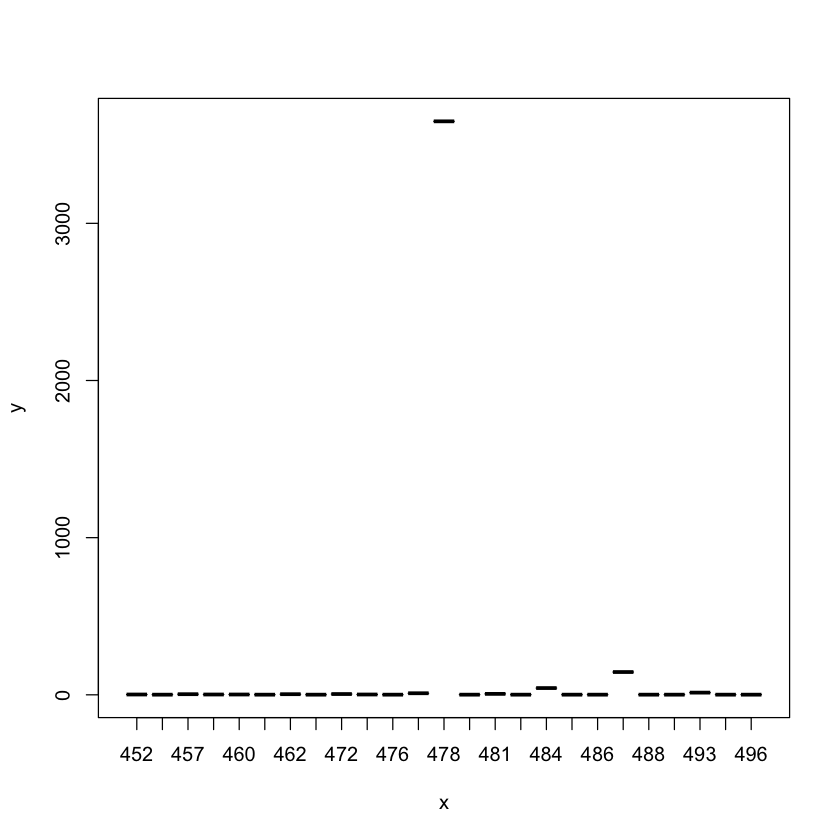

In [21]:
length.histogram <- as.data.frame(table(nchar(getSequences(seqtab.filt))))
plot(x=length.histogram[,1], y=length.histogram[,2])
pdf(paste(wdpath, "img/", "length_hist.pdf", sep=""))
plot(x=length.histogram[,1], y=length.histogram[,2])
dev.off()

### 15. Remove chimeras

In [22]:
seqtab.nochim <- removeBimeraDenovo(seqtab.filt, method="pooled", multithread=T, verbose=T)
dim(seqtab.nochim)
sum(seqtab.nochim)/sum(seqtab.filt)

Identified 542 bimeras out of 3900 input sequences.



[1]   74 3358

[1] 0.974673

### 16. Processing summary

In [23]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, sapply(dadaFs, getN), sapply(dadaRs, getN), sapply(mergers, getN), rowSums(seqtab.nochim))
colnames(track) <- c("input", "filtered", "denoisedF", "denoisedR", "merged", "nochimeras")
rownames(track) <- sample.names
track

,input,filtered,denoisedF,denoisedR,merged,nochimeras
PCRBlank45,1813,833,830,833,289,289
PCRBlank46,8,8,1,1,1,0
PCRBlank47,6254,5112,5100,5098,4927,4879
UF102PFR,3384,2900,2844,2843,2607,2109
UF106PFR,11281,9623,9495,9427,9239,8656
UF10PD,5839,5510,5423,5360,5185,4760
UF115PD,24981,23984,23526,23596,23138,21458
UF12PD,3843,3355,3317,3278,3111,2977
UF13PF,5618,5339,5277,5166,5099,4707
UF14PF,6886,6404,6302,6271,6067,5831


### 17. Save output

In [24]:
write.table(data.frame("row_names"=rownames(track),track),"read_retention.txt", row.names=FALSE, quote=F, sep="\t")
uniquesToFasta(seqtab.nochim, "rep_set.fa")
system("awk '/^>/{print \">ASV\" ++i; next}{print}' < rep_set.fa > rep_set_fix.fa")
system("mv rep_set_fix.fa rep_set.fa")

### 18. Clean up ASV names

In [25]:
my_otu_table <- t(as.data.frame(seqtab.nochim)) 
ASV.seq <- as.character(unclass(row.names(my_otu_table))) 
ASV.num <- paste0("ASV", seq(ASV.seq), sep='') 
colnames(seqtab.nochim) <- ASV.num 
write.table(data.frame("row_names"=rownames(seqtab.nochim),seqtab.nochim),"sequence_table.merged.txt", row.names=FALSE, quote=F, sep="\t")